# **Data Preparation**

## Zihe Wang, zw2624@columbia.edu

This notebook is used to visualization demo, data preprocessing, and train-val-test split. The notebook is based on the 'project_starter_code.ipynb', and will use openslide tools


In [3]:
%%capture
!apt-get install openslide-tools
!pip install openslide-python

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
import pathlib
from skimage.color import rgb2gray
from google.colab import drive
from data_utils import read_slide, find_tissue_pixels, apply_mask

## Exploration

I saved the data on my google drive

In [5]:
drive.mount('/gdrive',force_remount=True)
data_root = pathlib.Path('/gdrive/My Drive/adl_final')

Mounted at /gdrive


In [6]:
all_mask_paths = sorted([os.path.join(data_root, i) for i in os.listdir(data_root) if 'mask' in i])
all_image_paths = sorted([os.path.join(data_root, i) for i in os.listdir(data_root) if 'mask' not in i and '.tif' in i])

In [7]:
print(len(all_mask_paths))
assert len(all_mask_paths) == len(all_image_paths)

18


due to the storage size, I only used 18 out of 21 for this task

In [8]:
def generate_patch_random(image_slide, mask_slide, base_level=4, level=0, x=None, y=None, patch_size=299):

    slide_image = read_slide(image_slide, 
                0, 
                0, 
                level, 
                width=mask_slide.level_dimensions[base_level][0], 
                height=mask_slide.level_dimensions[base_level][1])
    downsample = image_slide.level_downsamples[base_level]
    if x is None:
        x = np.random.randint(0, slide_image.shape[1] - patch_size)
    if y is None:
	    y = np.random.randint(0, slide_image.shape[0] - patch_size)
    patch_image = read_slide(image_slide, 
		                     x=int(x*downsample-patch_size//2 * image_slide.level_downsamples[level]),
		                     y=int(y*downsample-patch_size//2 * image_slide.level_downsamples[level]),
		                     level=level,
		                     width=patch_size,
		                     height=patch_size)
    patch_image_mask = read_slide(mask_slide, 
		                     x=int(x*downsample-patch_size//2 * image_slide.level_downsamples[level]),
		                     y=int(y*downsample-patch_size//2 * image_slide.level_downsamples[level]),
		                     level=level,
		                     width=patch_size,
		                     height=patch_size)
    return patch_image, patch_image_mask

### Example figure

I used the base zoom level 4, and the followings are the patches at different level

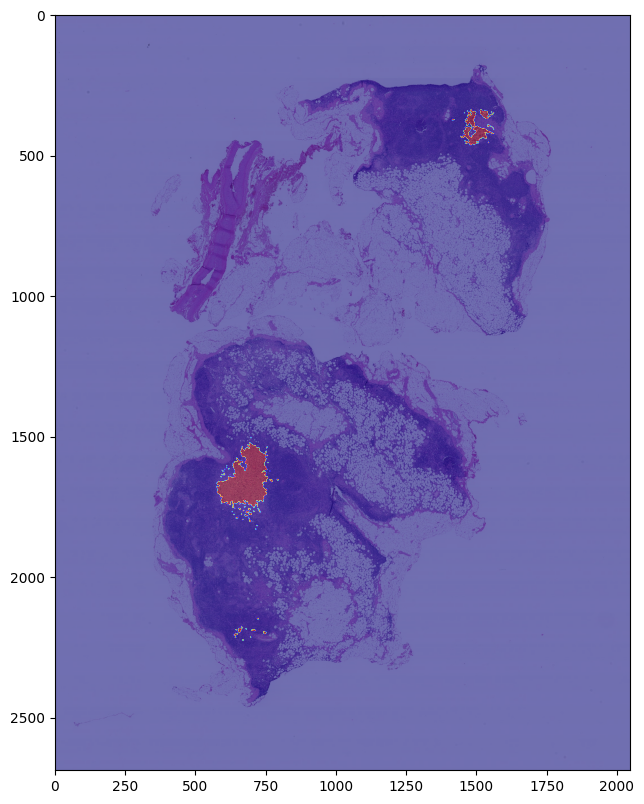

In [9]:
level=5
image_slide = open_slide(str(all_image_paths[12]))
image = read_slide(image_slide, 
        x=0, 
        y=0, 
        level=level, 
        width=image_slide.level_dimensions[level][0], 
        height=image_slide.level_dimensions[level][1])

mask_slide = open_slide(str(all_mask_paths[12]))
mask_image = read_slide(mask_slide, 
        x=0, 
        y=0, 
        level=level, 
        width=mask_slide.level_dimensions[level][0], 
        height=mask_slide.level_dimensions[level][1])
mask_image = mask_image[:,:,0]
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

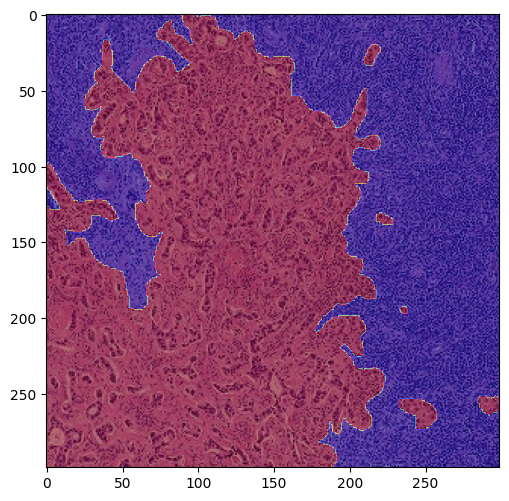

In [11]:
patch_example, patch_example_mask = generate_patch_random(image_slide, mask_slide, base_level=5, level=4, x=720, y=1600, patch_size=299)
patch_example_mask = patch_example_mask[:, :, 0]
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(patch_example)
plt.imshow(patch_example_mask, cmap='jet', alpha=0.5)

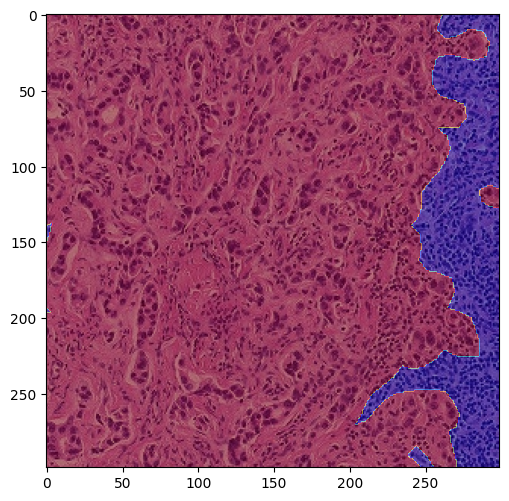

In [13]:
patch_example, patch_example_mask = generate_patch_random(image_slide, mask_slide, base_level=5, level=3, x=720, y=1600, patch_size=299)
patch_example_mask = patch_example_mask[:, :, 0]
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(patch_example)
plt.imshow(patch_example_mask, cmap='jet', alpha=0.5)

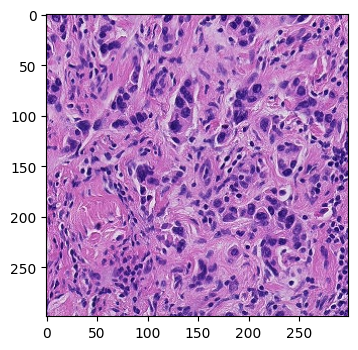

In [19]:
patch_example, patch_example_mask = generate_patch_random(image_slide, mask_slide, base_level=5, level=2, x=720, y=1600, patch_size=299)
patch_example_mask = patch_example_mask[:, :, 0]
plt.figure(dpi=100)
plt.imshow(patch_example)
plt.imshow(patch_example_mask, cmap='jet', alpha=0)

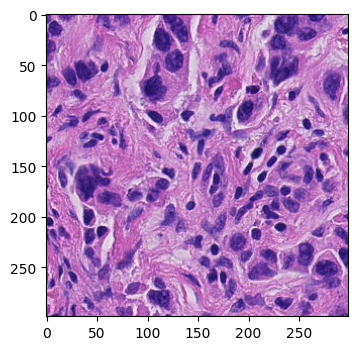

In [20]:
patch_example, patch_example_mask = generate_patch_random(image_slide, mask_slide, base_level=5, level=1, x=720, y=1600, patch_size=299)
patch_example_mask = patch_example_mask[:, :, 0]
plt.figure(dpi=100)
plt.imshow(patch_example)
plt.imshow(patch_example_mask, cmap='jet', alpha=0)

So, I will use level-1 and level-2 to train my model, as level-3 is so large a region to use as context. 

## Preprocessing and Train-Val-Test split

Since I have 18 in total, I used 13 as training, 2 as validation and 3 as test set.

Validation:

In [122]:
random.sample(all_image_paths, 2)

['/gdrive/My Drive/adl_final/tumor_084.tif',
 '/gdrive/My Drive/adl_final/tumor_019.tif']

Test

In [124]:
random.sample([p for p in all_image_paths if p not in ['/gdrive/My Drive/adl_final/tumor_084.tif', '/gdrive/My Drive/adl_final/tumor_019.tif']], 3)

['/gdrive/My Drive/adl_final/tumor_016.tif',
 '/gdrive/My Drive/adl_final/tumor_012.tif',
 '/gdrive/My Drive/adl_final/tumor_031.tif']

So, I'm using #19 and #84 as validation, #12, #16 and #31 as test, and the rest are all training

In [126]:
val_image_paths = ['/gdrive/My Drive/adl_final/tumor_084.tif', '/gdrive/My Drive/adl_final/tumor_019.tif']
test_image_paths = ['/gdrive/My Drive/adl_final/tumor_016.tif', '/gdrive/My Drive/adl_final/tumor_012.tif', '/gdrive/My Drive/adl_final/tumor_031.tif']
train_image_paths = [p for p in all_image_paths if p not in val_image_paths + test_image_paths]

In [128]:
val_mask_paths = ['/gdrive/My Drive/adl_final/tumor_084_mask.tif', '/gdrive/My Drive/adl_final/tumor_019_mask.tif']
test_mask_paths = ['/gdrive/My Drive/adl_final/tumor_016_mask.tif', '/gdrive/My Drive/adl_final/tumor_012_mask.tif', '/gdrive/My Drive/adl_final/tumor_031_mask.tif']
train_mask_paths = [p for p in all_mask_paths if p not in val_mask_paths + test_mask_paths]

To generate the data, I used a naive approach:


*   randomly select x and y
*   check if this image contains enough tissue. If not, select again
*   assign label by checking if the center part of the image contains tumor
*   repeat until I have enough (and qual numbers of) both positive and negative labels



In [ ]:
def has_tumor(mask, patch_size = 299):
  gap = (patch_size - center_size) // 2
  return np.sum(mask[gap : gap + center_size, gap : gap + center_size]) > 0

def get_sample_from_slide(image_slide, mask_slide, n_sample=200, base_level=5, level1=2, level2=1, patch_size=299):
    n_pos = 0
    n_neg = 0
    level1_data = []
    level2_data = []
    labels = []
    slide_image = read_slide(image_slide, 0, 0, base_level, width=mask_slide.level_dimensions[base_level][0], height=mask_slide.level_dimensions[base_level][1])
    while True:
        downsample = image_slide.level_downsamples[base_level]
        # random sample
        x = np.random.randint(0, slide_image.shape[1] - patch_size)
	    y = np.random.randint(0, slide_image.shape[0] - patch_size)
        patch_image, patch_image_mask = generate_patch_random(image_slide, mask_slide, base_level, level1, x, y, patch_size=299)
        patch_image2, patch_image_mask2 = generate_patch_random(image_slide, mask_slide, base_level, level2, x, y, patch_size=299)
        # check tissue
        tissue_pixels = find_tissue_pixels(patch_image2)
        tissue_percentage = len(list(tissue_pixels)) / patch_size**2 * 100
        if tissue_percentage < 0.4:
            continue
        has_tumor = check_tumor(patch_image_mask, patch_size)
        if has_tumor and n_pos < n_sample // 2:
            level1_data.append(patch_image)
            level2_data.append(patch_image2)
            labels.append(1)
            n_pos += 1
        if not has_tumor and n_neg < n_sample // 2:
            level1_data.append(patch_image)
            level2_data.append(patch_image2)
            labels.append(0)
            n_neg += 1
        if n_pos >= n_sample // 2 and n_neg >= n_sample // 2:
            break
    return level1_data, level2_data, labels

def generate_samples(image_paths, mask_paths, n_sample=2600, base_level=5, level1=2, level2=1, patch_size=299):
    n_each = n_sample // len(image_paths)
    level1_data_all = []
    level2_data_all = []
    labels_all = []
    for image_path, mask_path in zip(image_paths, mask_paths):
        image_slide = open_slide(image_path)
        mask_path = open_slide(mask_path)
        level1_data, level2_data, labels = get_sample_from_slide(image_slide, mask_slide, n_each, base_level, level1, level2, patch_size)
        level1_data_all = level1_data_all + level1_data
        level2_data_all = level2_data_all + level2_data
        labels_all = labels_all + labels
    return level1_data_all, level2_data_all, labels_all

In [ ]:
train_level1, train_level2, train_label = generate_samples(train_image_paths, train_mask_paths, n_sample=2600, base_level=5, level1=2, level2=1, patch_size=299)
val_level1, val_level2, val_label = generate_samples(val_image_paths, val_mask_paths, n_sample=500, base_level=5, level1=2, level2=1, patch_size=299)

Save to google drive

In [ ]:
trian_path = '/gdrive/My Drive/adl_final/train'
val_path = '/gdrive/My Drive/adl_final/val'

In [ ]:
np.save(trian_path+'/level1.npy', np.array(train_level1))
np.save(trian_path+'/level2.npy', np.array(train_level2))
np.save(trian_path+'/label.npy', np.array(train_label))

np.save(val_path+'/level1.npy', np.array(val_level1))
np.save(val_path+'/level2.npy', np.array(val_level2))
np.save(val_path+'/label.npy', np.array(val_label))

check saved results

In [22]:
trian_path = '/gdrive/My Drive/adl_final/train'
val_path = '/gdrive/My Drive/adl_final/val'

train_level1 = np.load(trian_path+'/level1.npy')
train_level2 = np.load(trian_path+'/level2.npy')
train_label = np.load(trian_path+'/label.npy')

Tumor


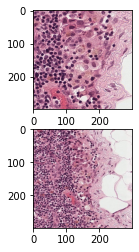

In [36]:
idx = random.randint(0, len(train_level1)-1)
if train_label[idx] == 0:
  print('Normal')
else:
  print('Tumor')
fig, axs = plt.subplots(2)
axs[0].imshow(train_level1[idx])
axs[1].imshow(train_level2[idx])